In [38]:
import time
import os
import requests

years = range(1990, 2023)
teams = ["ATL", "BOS", "NJN", "CHA", "CHI", "CLE", "DAL", "DEN", "DET", "GSW", "HOU", "IND",
         "LAC", "LAL", "MEM", "MIA", "MIL", "MIN", "NOH", "NYK", "OKC", "ORL", "PHI", "PHO",
         "POR", "SAC", "SAS", "TOR", "UTA", "WAS"]

DATA SCRAPING:

In [39]:
url_start_players = "https://www.basketball-reference.com/leagues/NBA_{}_per_game.html"
for year in years:
    f_path = "players/{}.html".format(year)
    if not os.path.isfile(f_path):
        url_players = url_start_players.format(year)
        data = requests.get(url_players)
    
        with open(f_path, "w+", encoding='utf8') as f:
            f.write(data.text)
    
        time.sleep(1.5)

In [40]:
url_start_teams = "https://www.basketball-reference.com/teams/{}/stats_per_game_totals.html"
for team in teams:
    f_path = "teams/{}.html".format(team)
    if not os.path.isfile(f_path):
        url_teams = url_start_teams.format(team)
        data = requests.get(url_teams)
    
        with open(f_path, "w+", encoding='utf8') as f:
            f.write(data.text)
    
        time.sleep(1.5)

---------------------------------------------------------------------------





DATA CLEANING:

In [41]:
from io import StringIO

from bs4 import BeautifulSoup
import pandas as pd

In [42]:
def clean_theads(b_soup):
    theads = b_soup.find_all('tr', class_="thead")
    for thead in theads:
        thead.decompose()


def remove_cols(b_soup, data_stats):
    thead = b_soup.find_all('th')
    for elem in thead:
        if elem['data-stat'] in data_stats:
            elem.decompose()

    to_remove = b_soup.find_all('td')
    for elem in to_remove:
        if elem['data-stat'] in data_stats:
            elem.decompose()


def clean_partial_tables(b_soup):
    partial_tabs = b_soup.find_all('tr', class_="italic_text partial_table") + b_soup.find_all('tr', class_="italic_text partial_table rowSum")
    while len(partial_tabs) != 0:
        tab = partial_tabs[0]
        next_siblings = [tab.find_next_sibling('tr')]
        previous_sibling = tab.find_previous_sibling('tr')
        i = 0
        while next_siblings[i].find_next_sibling('tr') and str(next_siblings[i].contents[1].contents[0].contents[0]) == str(next_siblings[i].find_next_sibling('tr').contents[1].contents[0].contents[0]):
            next_siblings.append(next_siblings[i].find_next_sibling('tr'))
            i += 1

        games_played_this = int(tab.contents[5].contents[0])
        games_played_next = -1
        next_max_sib = None
        for sib in next_siblings:
            if int(sib.contents[5].contents[0]) > games_played_next:
                games_played_next = int(sib.contents[5].contents[0])
                if next_max_sib:
                    partial_tabs.remove(next_max_sib)
                    next_max_sib.decompose()
                next_max_sib = sib
            else:
                partial_tabs.remove(sib)
                sib.decompose()

        if games_played_this > games_played_next:
            partial_tabs.remove(tab)
            partial_tabs.remove(next_max_sib)
            next_max_sib.decompose()
        else:
            partial_tabs.remove(next_max_sib)
            partial_tabs.remove(tab)
            tab.decompose()

        previous_sibling.decompose()

In [43]:
def clean_players():
    year_data = {}
    for year in years:
        with (open(f"players/{year}.html", encoding='utf8') as f):
            page = f.read()
            soup = BeautifulSoup(page, "html.parser")

            clean_theads(soup)

            clean_partial_tables(soup)

            ds_to_remove = ['age', 'pos', 'gs', 'mp_per_g', 'fg_per_g', 'fga_per_g', 'fg_pct', 'fg3_per_g', 'fg3a_per_g', 'fg3_pct', 
                            'fg2_per_g', 'fg2a_per_g', 'fg2_pct', 'ft_per_g', 'fta_per_g', 'ft_pct', 'orb_per_g', 'drb_per_g',
                            'efg_pct']

            remove_cols(soup, ds_to_remove)

            players_tab = soup.find_all(id="per_game_stats")
            players_readed_tab = pd.read_html(StringIO(str(players_tab)))
            year_data.update({year: players_readed_tab[0]})

    return year_data


data_players = clean_players()

In [44]:
def clean_teams():
    year_data = {}
    for team in teams:
        with (open(f"teams/{team}.html", encoding='utf8') as f):
            page = f.read()
            soup = BeautifulSoup(page, "html.parser")

            clean_theads(soup)

            ds_to_remove = ['team_id', 'losses', 'rank_team', 'foo', 'avg_age', 'avg_ht', 'avg_wt', 'mp_per_g', 
                            'fg_per_g', 'fga_per_g', 'fg_pct', 'fg3_per_g', 'fg3a_per_g', 'fg3_pct', 'fg2_per_g', 
                            'fg2a_per_g', 'fg2_pct', 'ft_per_g', 'fta_per_g', 'ft_pct', 'orb_per_g', 'drb_per_g']

            remove_cols(soup, ds_to_remove)

            teams_tab = soup.find_all(id="stats")
            teams_readed_tab = pd.read_html(StringIO(str(teams_tab)))

            year_data.update({team: teams_readed_tab[0]})

    return year_data


data_teams = clean_teams()

In [109]:
pd.set_option('display.expand_frame_repr', False)
print(data_players[1990])

      Rk                 Player   Tm   G   TRB   AST  STL  BLK  TOV   PF   PTS
0      1             Mark Acres  ORL  80   5.4   0.8  0.5  0.3  0.9  3.1   4.5
1      2          Michael Adams  DEN  79   2.8   6.3  1.5  0.0  1.8  1.7  15.5
2      3           Mark Aguirre  DET  78   3.9   1.9  0.4  0.2  1.6  2.6  14.1
3      4            Danny Ainge  SAC  75   4.3   6.0  1.5  0.2  2.5  3.2  17.9
4      5            Mark Alarie  WSB  82   4.6   1.7  0.7  0.5  1.2  2.7  10.5
5      6           Steve Alford  DAL  41   0.6   1.0  0.4  0.1  0.4  0.5   4.1
6      7            Randy Allen  SAC  63   2.2   0.4  0.3  0.3  0.4  1.6   3.7
7      8          Greg Anderson  MIL  60   6.2   0.4  0.5  0.9  1.3  2.9   8.8
8      9          Nick Anderson  ORL  81   3.9   1.5  0.9  0.4  1.7  1.7  11.5
9     10       Richard Anderson  CHH  54   2.4   1.0  0.4  0.2  0.5  1.2   4.3
10    11           Ron Anderson  PHI  78   3.8   1.8  0.9  0.2  1.0  1.8  11.9
11    12        Willie Anderson  SAS  82   4.5   4.4

----------------------------------------------------------------------------

WYPEŁNIENIE WARTOŚCI NaN ŚREDNIMI W KOLUMNACH:

In [45]:
for team in teams:
    mean_val = data_teams[team].mean(numeric_only=True)
    rounded_mean = mean_val.round(1)
    data_teams[team] = data_teams[team].fillna(rounded_mean)
    
    
for year in years:
    mean_val = data_players[year].mean(numeric_only=True)
    rounded_mean = mean_val.round(1)
    data_players[year] = data_players[year].fillna(rounded_mean)

-------------------------------------------------------------------------
DODANIE KOLUMNY Z PROCENTEM WYGRANYCH:

In [46]:
for team in teams:
    data_teams[team]['win_percentage'] = round(data_teams[team]['W'] / data_teams[team]['G'], 3)

-------------------------------------------------------------------------
ANALIZA WPŁYWU POSZCZEGÓLNYCH STATYSTYK NA WYNIK ZESPOŁU

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [108]:
pd.set_option('display.expand_frame_repr', False)
# print(data_teams['SAS'])

independent_vars = ['TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']
def get_results_lin(teams_data):
    coefficients = []
    bs = []
    Y_preds = []
    X_tests = []
    for team in teams:
        t_data = teams_data[team]
        X = t_data[independent_vars]
        Y = t_data['win_percentage']
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
        
        model = LinearRegression()
        model.fit(X_train, Y_train)
        Y_pred = model.predict(X_test)
        # mse_lin_train = mean_squared_error(Y_train, model.predict(X_train))
        # print(f'Mean squared error train (lin): {mse_lin_train:0.3}\n')
        mse_lin = mean_squared_error(Y_test, Y_pred)
        print(f'Team name: {team}')
        print(f'Mean squared error (lin): {mse_lin:0.3}\n')
        
        coefficients.append(model.coef_)
        bs.append(model.intercept_)
        Y_preds.append(Y_pred)
        X_tests.append(X_test)
        
        
    coeff_df = pd.DataFrame(coefficients, columns=independent_vars)
    
    return coeff_df, Y_preds, X_tests, bs

coeffs_df_lin, Y_preds_lin, X_tests_lin, bs_lin = get_results_lin(data_teams)
mean_coeffs_lin = coeffs_df_lin.mean()
print("Średnie współczynniki regresji dla całej ligi:")
print(mean_coeffs_lin)

     Season   Lg   W   G   TRB   AST   STL  BLK   TOV    PF    PTS  win_percentage
0   2023-24  NBA  22  82  44.2  29.9   7.1  6.3  15.1  17.2  112.1           0.268
1   2022-23  NBA  22  82  43.7  27.2   7.0  3.9  15.3  19.9  113.0           0.268
2   2021-22  NBA  34  82  45.3  27.9   7.6  4.9  12.7  18.1  113.2           0.415
3   2020-21  NBA  33  72  43.9  24.4   7.0  5.1  11.4  18.0  111.1           0.458
4   2019-20  NBA  32  71  44.6  24.7   7.3  5.5  12.6  19.4  114.1           0.451
5   2018-19  NBA  48  82  44.7  24.5   6.1  4.7  12.1  18.1  111.7           0.585
6   2017-18  NBA  47  82  44.2  22.8   7.7  5.6  13.1  17.2  102.7           0.573
7   2016-17  NBA  61  82  43.9  23.8   8.0  5.9  13.4  18.3  105.3           0.744
8   2015-16  NBA  67  82  43.9  24.5   8.3  5.9  13.1  17.5  103.5           0.817
9   2014-15  NBA  55  82  43.6  24.4   8.0  5.4  14.0  19.1  103.2           0.671
10  2013-14  NBA  62  82  43.3  25.2   7.4  5.1  14.4  18.2  105.4           0.756
11  

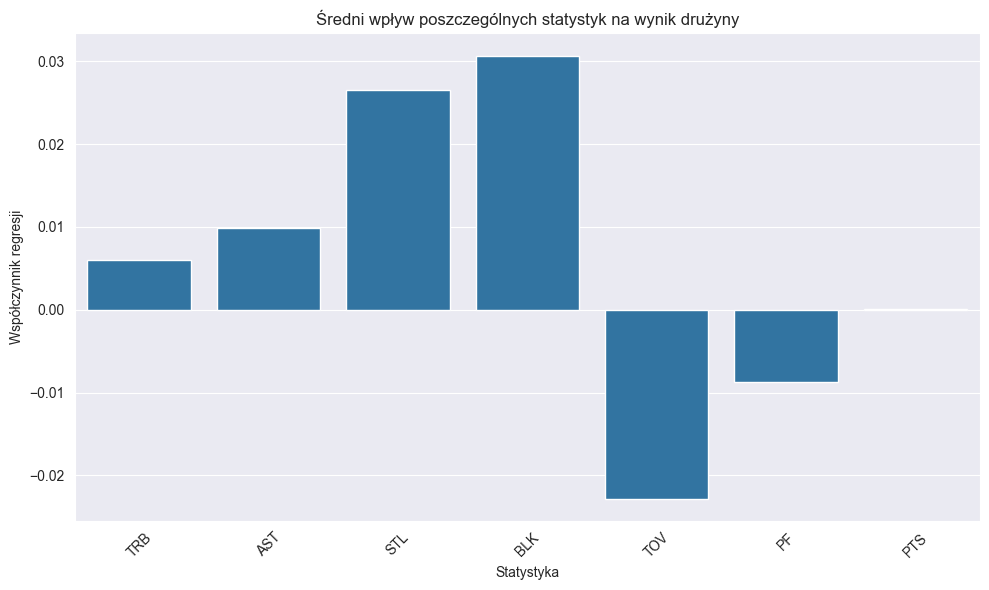

In [67]:
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_coeffs_lin.index, y=mean_coeffs_lin.values)
plt.title('Średni wpływ poszczególnych statystyk na wynik drużyny')
plt.xlabel('Statystyka')
plt.ylabel('Współczynnik regresji')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('barplot.jpg', transparent=True)
plt.show()

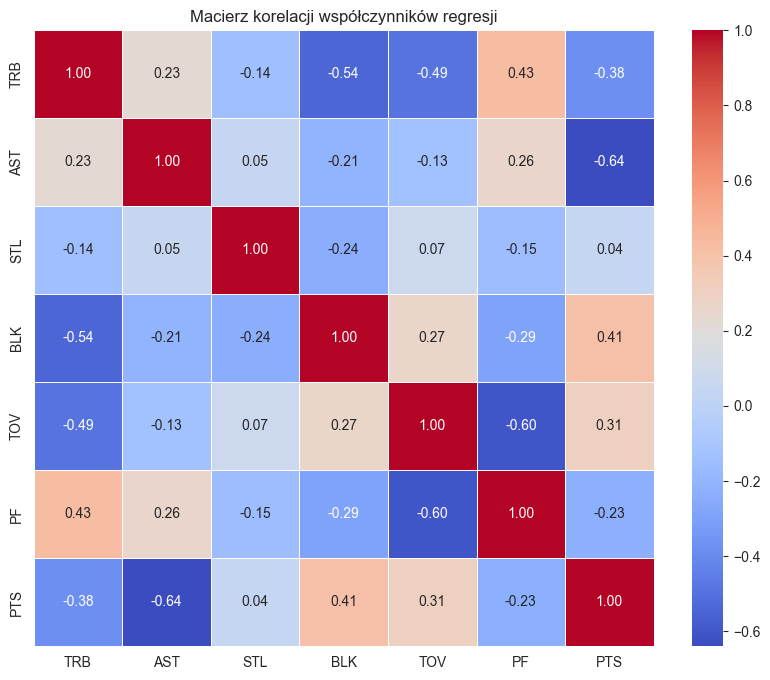

In [66]:
corr_matrix = coeffs_df_lin.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Macierz korelacji współczynników regresji')
plt.savefig('corr.jpg', transparent=True)
plt.show()

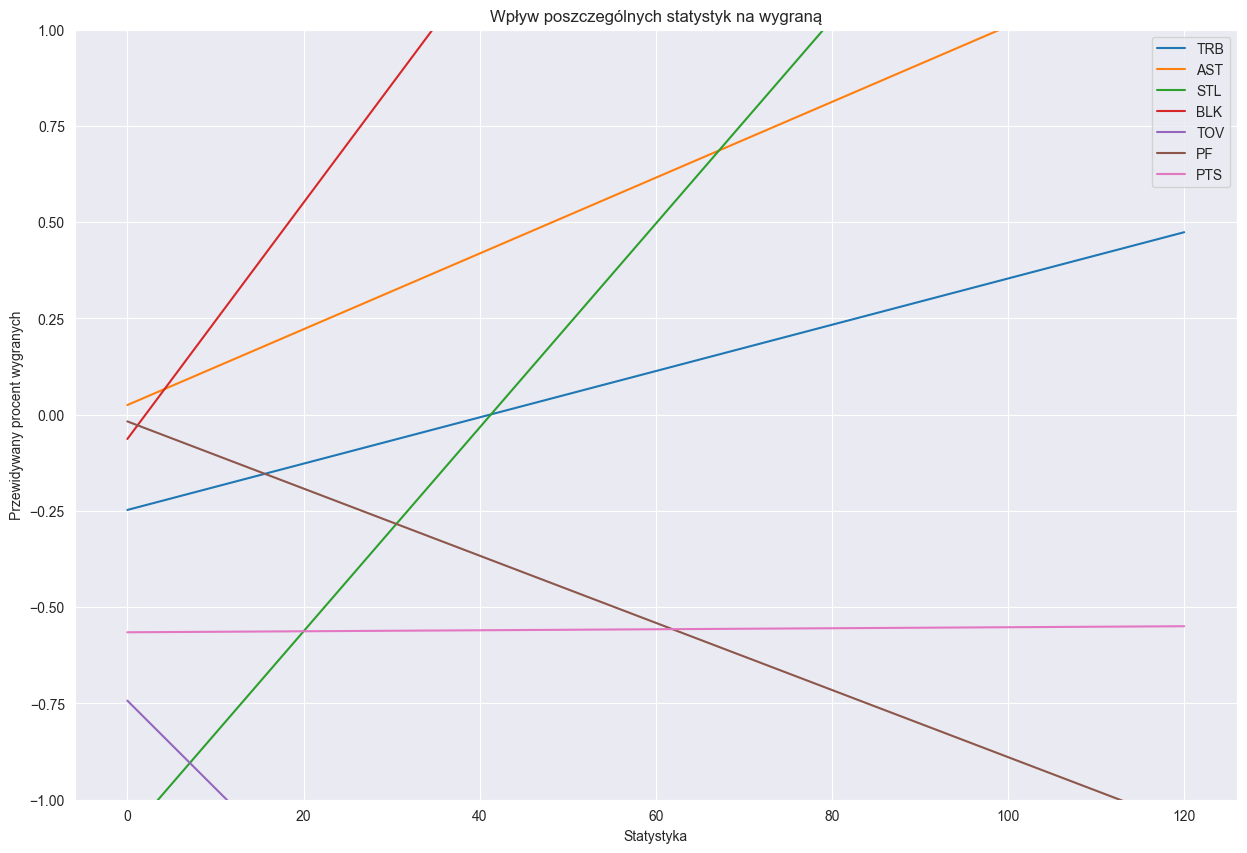

In [65]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(independent_vars):
    a = mean_coeffs_lin.iloc[i]
    b = bs_lin[i]
    x_range = np.linspace(0, 120, 100)
    y_range = a * x_range + b
    
    plt.plot(x_range, y_range, label=col)
plt.title('Wpływ poszczególnych statystyk na wygraną')
plt.xlabel('Statystyka')
plt.ylabel('Przewidywany procent wygranych')
plt.ylim(-1, 1)
plt.legend()
plt.grid(True)
plt.savefig('reg_analiza.jpg', transparent=True)
plt.show()

----------------------------------------------------------------------------------------------
SPOSÓB 1 - OBLICZENIE WPŁYWU ZAWODNIKA NA PODSTAWIE ŚREDNICH WSPÓŁCZYNNIKÓW REGRESJI LINIOWEJ:

In [71]:
def calculate_player_impact(player_stats):
    impact = sum(mean_coeffs_lin[stat] * player_stats[stat] for stat in independent_vars)
    return impact


def get_team_players(players_data, year, team):
    year_data = (players_data[year])
    team_players = year_data[year_data['Tm'] == team]
    
    return team_players


def get_changes(players_data, year, team):
    if year not in range(1991, 2023):
        raise ValueError(f"Year {year} is out of range")
    prev_year = year - 1
    
    prev_team = get_team_players(players_data, prev_year, team)
    this_team = get_team_players(players_data, year, team)
    
    incoming_players = this_team[~this_team['Player'].isin(prev_team['Player'])]
    outgoing_players = prev_team[~prev_team['Player'].isin(this_team['Player'])]
    
    return incoming_players, outgoing_players


def predict_season_outcome(changes):
    season_win_percentage_change = sum(calculate_player_impact(row) for index, row in changes[0].iterrows()) - sum(calculate_player_impact(row) for index, row in changes[1].iterrows())
    return season_win_percentage_change


def get_season(year):
    previous_year = year - 1
    season = f"{previous_year}-{str(year)[2:]}"
    
    return season


def calc_changes_diff(changes, team, actual_pct, prev_pct):
    incoming_sum = changes[0].select_dtypes(include='number').sum()
    outgoing_sum = changes[1].select_dtypes(include='number').sum()
    
    stats_diff = incoming_sum - outgoing_sum
    stats_diff['year'] = actual_pct
    stats_diff['prev_year'] = prev_pct
    stats_diff['team'] = team
    return stats_diff


all_changes = []
pred_changes = []
actual_changes = []
for team in teams:
    t_data = data_teams[team]
    start_season = 1991 if team not in ['MEM', 'NOH'] else (2004 if team == 'NOH' else 1997)
    for year in range(start_season, 2023):
        year_row = t_data[t_data['Season'] == get_season(year)]
        prev_year_row = t_data[t_data['Season'] == get_season(year - 1)]
        if len(year_row) != 0 and len(prev_year_row) != 0:
            actual_percentage = year_row['win_percentage'].iloc[0]
            prev_win_percentage = prev_year_row['win_percentage'].iloc[0]
            actual_changes.append(actual_percentage - prev_win_percentage)
            team_changes = get_changes(data_players, year, team)
            
            predicted_percentage = predict_season_outcome(team_changes)
            pred_changes.append(predicted_percentage)
            
            changes_diff = calc_changes_diff(team_changes, team, actual_percentage, prev_win_percentage)
            all_changes.append(changes_diff)
        
        
years_percentage_df = pd.DataFrame({'Rzeczywista zmiana procentu wygranych': actual_changes,
                                    'Przewidywana zmiana procentu wygranych': pred_changes})
print(years_percentage_df)

mse = mean_squared_error(actual_changes, pred_changes)
print(f'Mean squared error (lin merged): {mse:0.3}\n')

     Rzeczywista zmiana procentu wygranych  \
0                                    0.024   
1                                   -0.061   
2                                    0.061   
3                                    0.171   
4                                   -0.183   
5                                    0.049   
6                                    0.122   
7                                   -0.073   
8                                    0.010   
9                                   -0.279   
10                                  -0.036   
11                                   0.097   
12                                   0.025   
13                                  -0.086   
14                                  -0.182   
15                                   0.158   
16                                   0.049   
17                                   0.085   
18                                   0.122   
19                                   0.073   
20                                

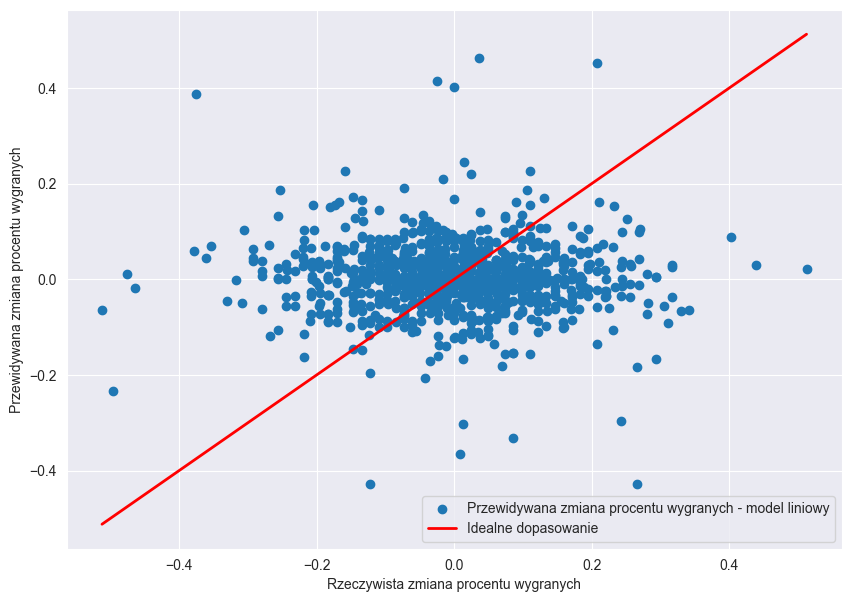

In [72]:
x_axis = np.arange(len(actual_changes))[::8]

plt.figure(figsize=(10,7))
plt.scatter(actual_changes, pred_changes, label='Przewidywana zmiana procentu wygranych - model liniowy')
plt.plot([min(actual_changes), max(actual_changes)], [min(actual_changes), max(actual_changes)], color='red', lw=2, label='Idealne dopasowanie')

plt.legend()
plt.xlabel('Rzeczywista zmiana procentu wygranych')
plt.ylabel('Przewidywana zmiana procentu wygranych')
plt.savefig('linear_model.jpg', transparent=True)
plt.show()

-------------------------------------------------------------------------
SPOSÓB 2 - BEZPOŚREDNIE TRENOWANIE MODELU NA ZMIANACH W DRUŻYNACH

In [107]:
from sklearn.svm import SVR

all_changes_df = pd.DataFrame(all_changes)
X = all_changes_df[independent_vars]
Y = all_changes_df['prev_year'] - all_changes_df['year']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

pd.set_option('display.expand_frame_repr', False)
print(all_changes_df)


model = LinearRegression()
model.fit(X_train, Y_train)
Y_pred_lin_merged = model.predict(X_test)

# mse_lin_train = mean_squared_error(Y_train, model.predict(X_train))
# print(f'Mean squared error train (lin merged): {mse_lin_train:0.3}\n')

mse_lin = mean_squared_error(Y_test, Y_pred_lin_merged)
print(f'Mean squared error (lin merged): {mse_lin:0.3}\n')


model_SVR = SVR(kernel='rbf', gamma='scale', C=1)

model_SVR.fit(X_train, Y_train)
Y_pred_svm = model_SVR.predict(X_test)

# mse_svr_train = mean_squared_error(Y_train, model_SVR.predict(X_train))
# print(f'Mean squared error train (lin): {mse_svr_train:0.3}\n')

mse_svr = mean_squared_error(Y_test, Y_pred_svm)
print(f'Mean squared error (svm): {mse_svr:0.3}\n')

         Rk      G           TRB           AST           STL           BLK           TOV            PF    PTS   year  prev_year team
0    -280.0  -66.0 -4.300000e+00 -5.900000e+00 -1.400000e+00 -8.000000e-01 -8.000000e-01 -5.100000e+00  -17.5  0.524      0.500  ATL
1     291.0   -1.0  2.100000e+00  2.700000e+00  1.600000e+00  0.000000e+00  7.000000e-01  4.400000e+00    1.5  0.463      0.524  ATL
2   -1000.0  -38.0  2.300000e+00 -3.800000e+00 -1.100000e+00  2.000000e-01 -1.100000e+00 -5.000000e-01   -6.1  0.524      0.463  ATL
3    -153.0   90.0 -1.700000e+00  1.800000e+00  6.000000e-01  4.000000e-01 -6.000000e-01 -1.900000e+00    1.7  0.695      0.524  ATL
4     260.0  113.0  2.000000e-01  3.300000e+00  1.300000e+00  6.000000e-01  1.700000e+00  5.700000e+00   -4.1  0.512      0.695  ATL
5      31.0  -60.0 -1.900000e+00 -1.500000e+00 -4.000000e-01 -4.000000e-01  1.100000e+00 -2.100000e+00    4.6  0.561      0.512  ATL
6     110.0  120.0  1.540000e+01 -8.000000e-01 -6.000000e-01  1.80000

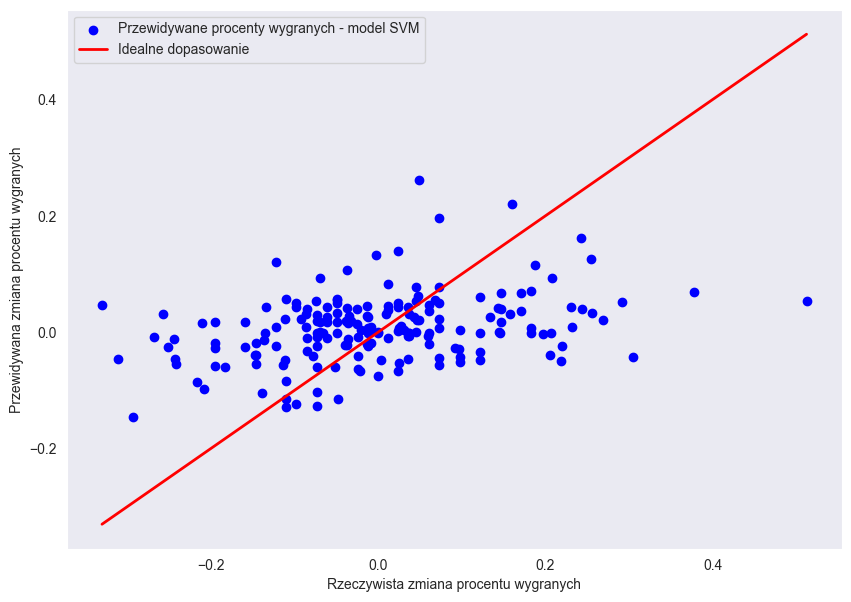

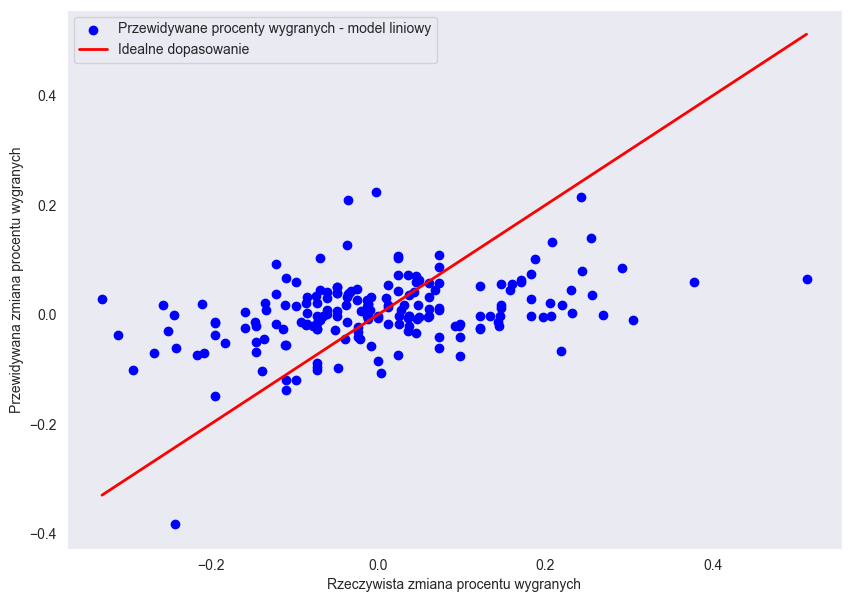

In [92]:
plt.figure(figsize=(10,7))

os_x = np.linspace(0, 120, 305)
plt.scatter(Y_test, Y_pred_svm, color='blue', label='Przewidywane procenty wygranych - model SVM')
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], color='red', lw=2, label='Idealne dopasowanie')

plt.xlabel('Rzeczywista zmiana procentu wygranych')
plt.ylabel('Przewidywana zmiana procentu wygranych')
plt.legend()
plt.grid()
plt.savefig('svm_model.jpg', transparent=True)
plt.show()


plt.figure(figsize=(10,7))

plt.scatter(Y_test, Y_pred_lin_merged, color='blue', label='Przewidywane procenty wygranych - model liniowy')
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], color='red', lw=2, label='Idealne dopasowanie')

plt.xlabel('Rzeczywista zmiana procentu wygranych')
plt.ylabel('Przewidywana zmiana procentu wygranych')
plt.legend()
plt.grid()
plt.savefig('linear_model_merged.jpg', transparent=True)
plt.show()